In [7]:
using PyCall
println(PyCall.python)

/Users/miyata/spin-system-simulations/.venv/bin/python


In [2]:
include("IsingCore.jl")
using .IsingCore
using StochasticAD
using CairoMakie
using Optimisers
using LinearAlgebra
using Statistics: mean, std

println(names(IsingCore))

# hyper parameters
T0 = [5.0]
N = 6 # size of the lattice, N x N

function optimize(θ0; move=IsingCore.independent_sampler, is_move=false, η=0.01, n=200, n_batch=1)
    optimizer = Adam(η)
    θ = deepcopy(θ0)
    θ_trace = [θ]
    setup = Optimisers.setup(optimizer, θ)
    for i in 1:n
        samples = [derivative_estimate(T -> obj(T; move, is_move), θ[1]) for _ in 1:n_batch]
        g = mean(samples)
        s = std(samples)
        setup, θ = Optimisers.update(setup, θ, g)
        push!(θ_trace, deepcopy(θ))
        if i % 10 == 0
            println("Iteration $i: mean = $g, std = $s, T = $(θ[1])")
        end
    end
    return θ_trace
end

function obj(T; move=IsingCore.independent_sampler, is_move=false)
    config = IsingCore.initial_state(N)
    if is_move
        -IsingCore.ising_model_remc(N, T, config, move)[3]
    else
        -IsingCore.ising_model(N, T, config, move)[3]
    end
end

[:IsingCore, :calc_energy, :calc_mag, :independent_sampler, :initial_state, :ising_model, :ising_model_manyT, :ising_model_remc, :metropolis_sampler]


obj (generic function with 1 method)

In [3]:
θ_trace_re = optimize(T0; is_move=true, η=0.01, n=300, n_batch=50)
obj_trace_re = [-obj(θ[1]; is_move=true) for θ in θ_trace_re]
println("finish to optimize replica exchange.")

Iteration 10: mean = 1.9377124586098506, std = 0.49865968724093046, T = 4.899920934599623
Iteration 20: mean = 2.1286585565127107, std = 0.5193757486821288, T = 4.797967793225754
Iteration 30: mean = 2.45362589582478, std = 0.645092303118464, T = 4.693387142575796
Iteration 40: mean = 2.6106040590894453, std = 0.7531146932142274, T = 4.585301132945473
Iteration 50: mean = 2.9586797287497095, std = 1.3114635229349778, T = 4.472588188465633
Iteration 60: mean = 3.275477856595377, std = 1.1479810197165385, T = 4.355350414120914
Iteration 70: mean = 4.097315548468188, std = 1.9504369347927528, T = 4.2307967264414446
Iteration 80: mean = 4.488119705660773, std = 1.7397358532463507, T = 4.0990456136756555
Iteration 90: mean = 6.040571289309059, std = 2.499764500619618, T = 3.9588552149795393
Iteration 100: mean = 6.713048946665067, std = 3.2446841571336145, T = 3.808566152410468
Iteration 110: mean = 8.498643589441604, std = 4.356965247512995, T = 3.6447898872116413
Iteration 120: mean = 9.9

In [4]:
θ_trace = optimize(T0; η=0.01, n=300, n_batch=50)
obj_trace = [-obj(θ[1]) for θ in θ_trace]
println("finish to optimize.")

Iteration 10: mean = 1.8839855582232814, std = 0.5234174790679523, T = 4.899987748573521
Iteration 20: mean = 2.2587025263062386, std = 0.573962341633878, T = 4.798682329497617
Iteration 30: mean = 2.4028225444215368, std = 0.5915261290647496, T = 4.694055802710268
Iteration 40: mean = 2.6967110309508353, std = 0.7909311615486392, T = 4.585774379756603
Iteration 50: mean = 2.780819623784764, std = 0.7094312758286171, T = 4.472411551280827
Iteration 60: mean = 3.31213381503327, std = 1.1925761554736833, T = 4.353442266138368
Iteration 70: mean = 3.5073882190079155, std = 1.3096220157045502, T = 4.229452713225286
Iteration 80: mean = 4.687144842079507, std = 1.4534964724177892, T = 4.099342352621491
Iteration 90: mean = 5.423109621003349, std = 2.0658994335550127, T = 3.9588890779536134
Iteration 100: mean = 6.611612807610194, std = 2.4927550844521273, T = 3.808083543326009
Iteration 110: mean = 7.92769994697131, std = 3.185586866655539, T = 3.6478910027283775
Iteration 120: mean = 11.30

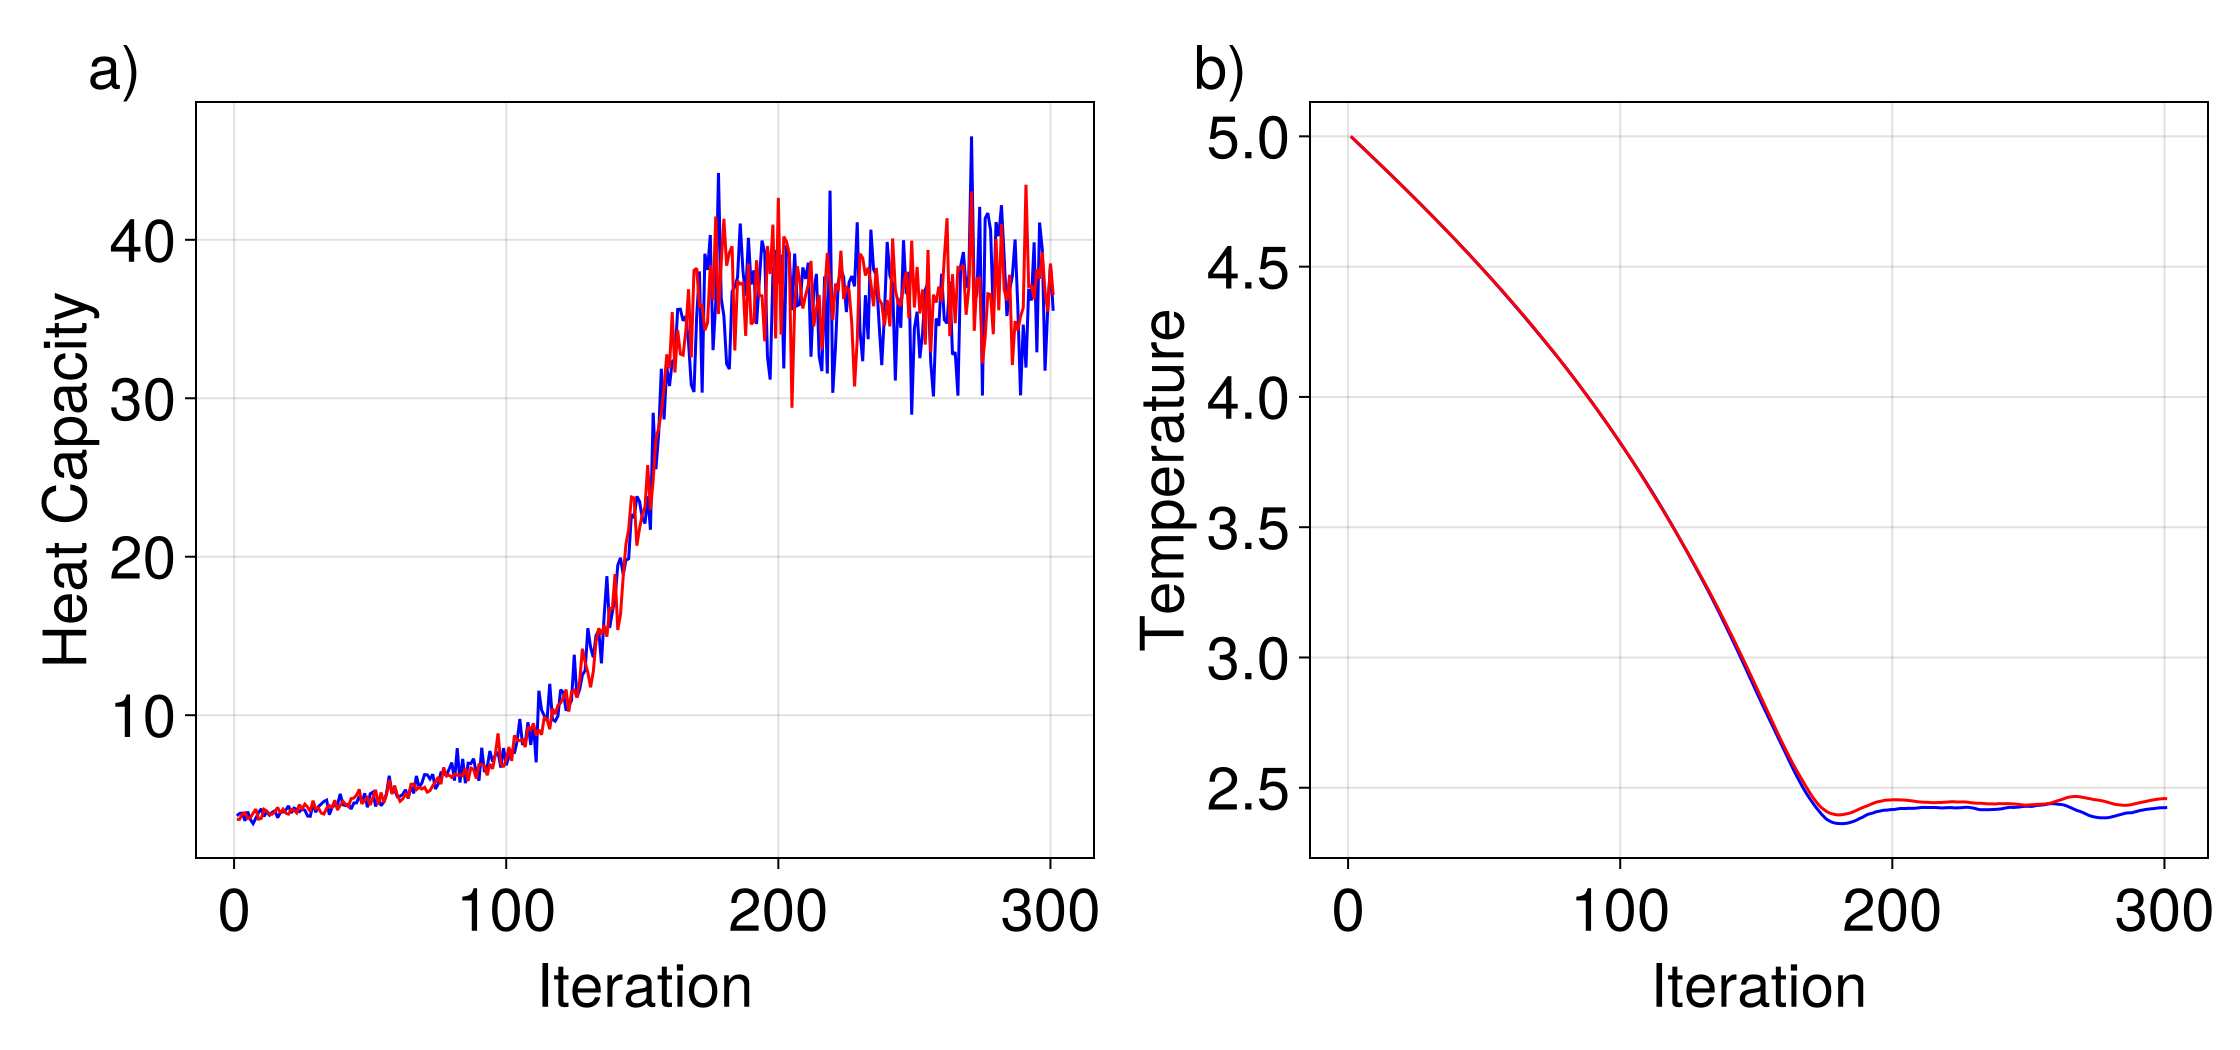

CairoMakie.Screen{IMAGE}


In [5]:
begin
    fig = Figure(size=(1120, 525), fontsize=30)
    ax1 = fig[1, 1] = Axis(fig, ylabel="Heat Capacity", xlabel="Iteration")
    ax2 = fig[1, 2] = Axis(fig, ylabel="Temperature", xlabel="Iteration")
    Label(fig[1, 1, TopLeft()], "a)")
    Label(fig[1, 2, TopLeft()], "b)")

    lines!(ax1, obj_trace, color=:blue, label="independent")
    lines!(ax1, obj_trace_re, color=:red, label="replica exchange")
    lines!(ax2, [θ[1] for θ in θ_trace], color=:blue, label="independent")
    lines!(ax2, [θ[1] for θ in θ_trace_re], color=:red, label="replica exchange")
    display(fig)
end